In [2]:
import time
import datetime as dt
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.recurrent import LSTM
#from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datalab.bigquery as bq
import pandas as pd
import numpy as np
import collections
import math
import shutil


In [67]:
def convertSPPMonthlyDA(fname, mkt):
    #fname = "data/DA-LMP-MONTHLY-SL-201608.csv"
    col_names = ['Date', 'Settlement Location Name', 'PNODE Name', 'Price Type', 'HE01','HE02','HE03','HE04','HE05','HE06','HE07','HE08','HE09','HE10','HE11','HE12','HE13','HE14','HE15','HE16','HE17','HE18','HE19','HE20','HE21','HE22','HE23','HE24']
    da_price = pd.read_csv(fname, header=0, names=col_names)
    df = pd.DataFrame(da_price)
    date_split = df['Date'].str.split('/').str
    market_days = collections.OrderedDict()

    for index, row in df.iterrows():
        nodes = collections.OrderedDict()
        hours = collections.OrderedDict()   

        if not market_days.has_key(row['Date'].replace("/","")):
            market_days[row['Date'].replace("/","")] = {}
        nodes = market_days.get(row['Date'].replace("/",""))

        if not nodes.has_key(row['Settlement Location Name']):
            nodes[row['Settlement Location Name']] = {}
        hours = nodes.get(row['Settlement Location Name'])

        for index in range(4,len(row)):
            index = index - 4
            #LMP, MCC, MLC
            prices = [0,0,0]
            if index<9:
                hourstring = 'HE0'+str(index+1)
            else:
                hourstring = 'HE'+str(index+1)

            if not hours.has_key(str(hourstring)):
                hours[hourstring] = prices
            prices = market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring]

            if row['Price Type'] == 'LMP':
                market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring][0] = row[hourstring]
            elif row['Price Type'] == 'MCC':
                market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring][1] = row[hourstring]
            elif row['Price Type'] == 'MLC':
                market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring][2] = row[hourstring]
    with open('spp%smarket.csv' % mkt, 'a') as out:
        #out.write('day,node,hour,lmp,mcc,mlc\n') #header
        for day in market_days.keys():
            for gen in market_days[day].keys():
                for hour in market_days[day][gen].keys():
                    if not math.isnan(market_days[day][gen][hour][0]):
                        out.write(day + "," + gen + "," + hour + "," + 
                                  str(market_days[day][gen][hour][0]) + "," + 
                                  str(market_days[day][gen][hour][1]) + "," + 
                                  str(market_days[day][gen][hour][2]) + "\n")

    with open('spp%smec.csv' % mkt, 'a') as out:
        #out.write('day,hour,mec\n') #header
        for day in market_days.keys():
            for hour in next(market_days[day].itervalues()).keys():
                if not math.isnan(next(market_days[day].itervalues())[hour][0]):
                    out.write(day + "," + hour + "," + 
                        str(next(market_days[day].itervalues())[hour][0] - next(market_days[day].itervalues())[hour][1] - next(market_days[day].itervalues())[hour][2]) + "\n")


In [106]:
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201607.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201608.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201609.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201610.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201611.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201612.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201701.csv",'da')
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201702.csv",'da')

In [69]:
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201607.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201608.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201609.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201610.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201611.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201612.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201701.csv",'rt')
convertSPPMonthlyDA("data/RTBM-LMP-MONTHLY-SL-201702.csv",'rt')

In [3]:
fname = "sppdamec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
#read_csv index_col=0, skiprows=1
#
mdf = pd.DataFrame(mec)
mdf['Hour'] = mdf['Hour'].str.lstrip('HE')
mdf = mdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
print(mdf.head())

      Date Hour      mec
0  8012016   01  28.9543
2  8012016   02  28.1353
1  8012016   03  23.0198
4  8012016   04  20.2738
3  8012016   05  19.6931


In [4]:
fname = "spprtmec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
rdf = pd.DataFrame(mec)
rdf['Hour'] = rdf['Hour'].str.lstrip('HE')
rdf = rdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
#for below need to set indexes first and also name columns based on mkt type too
#pd.merge(mdf,rdf, how='outer', left_index=True, right_index=True)
#can use column instead of index too, left_on=col right_on=[col1,col2] ...
mdf['rtmec'] = rdf['mec']
mdf['diffmec'] = mdf['mec']-mdf['rtmec']
mdf.tail()

,Date,Hour,mec,rtmec,diffmec
5090,20170301,02,18.7123,16.7582,1.9541
5089,20170301,03,16.6510,16.9305,-0.2795
5092,20170301,04,14.2374,2.3025,11.9349
5091,20170301,05,9.7113,2.1649,7.5464
5093,20170301,06,6.8771,5.5670,1.3101


In [31]:
xl, yl = mdf.shape
x = range(xl)
#fig, ax = plt.subplots()
obdates = np.arange('2016-08-01 01:00', '2017-03-01 07:00', dtype='datetime64[h]')
obdates = list(map(pd.to_datetime, obdates))
obdates[:5]


[Timestamp('2016-08-01 01:00:00'),
 Timestamp('2016-08-01 02:00:00'),
 Timestamp('2016-08-01 03:00:00'),
 Timestamp('2016-08-01 04:00:00'),
 Timestamp('2016-08-01 05:00:00')]

In [72]:
def runningMean(x,N):
  return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [85]:
print(len(runningMean(mdf['diffmec'], 100)))
print(len(mdf['diffmec']))
print(mdf['diffmec'][:100].mean())

5094
5094
3.586591


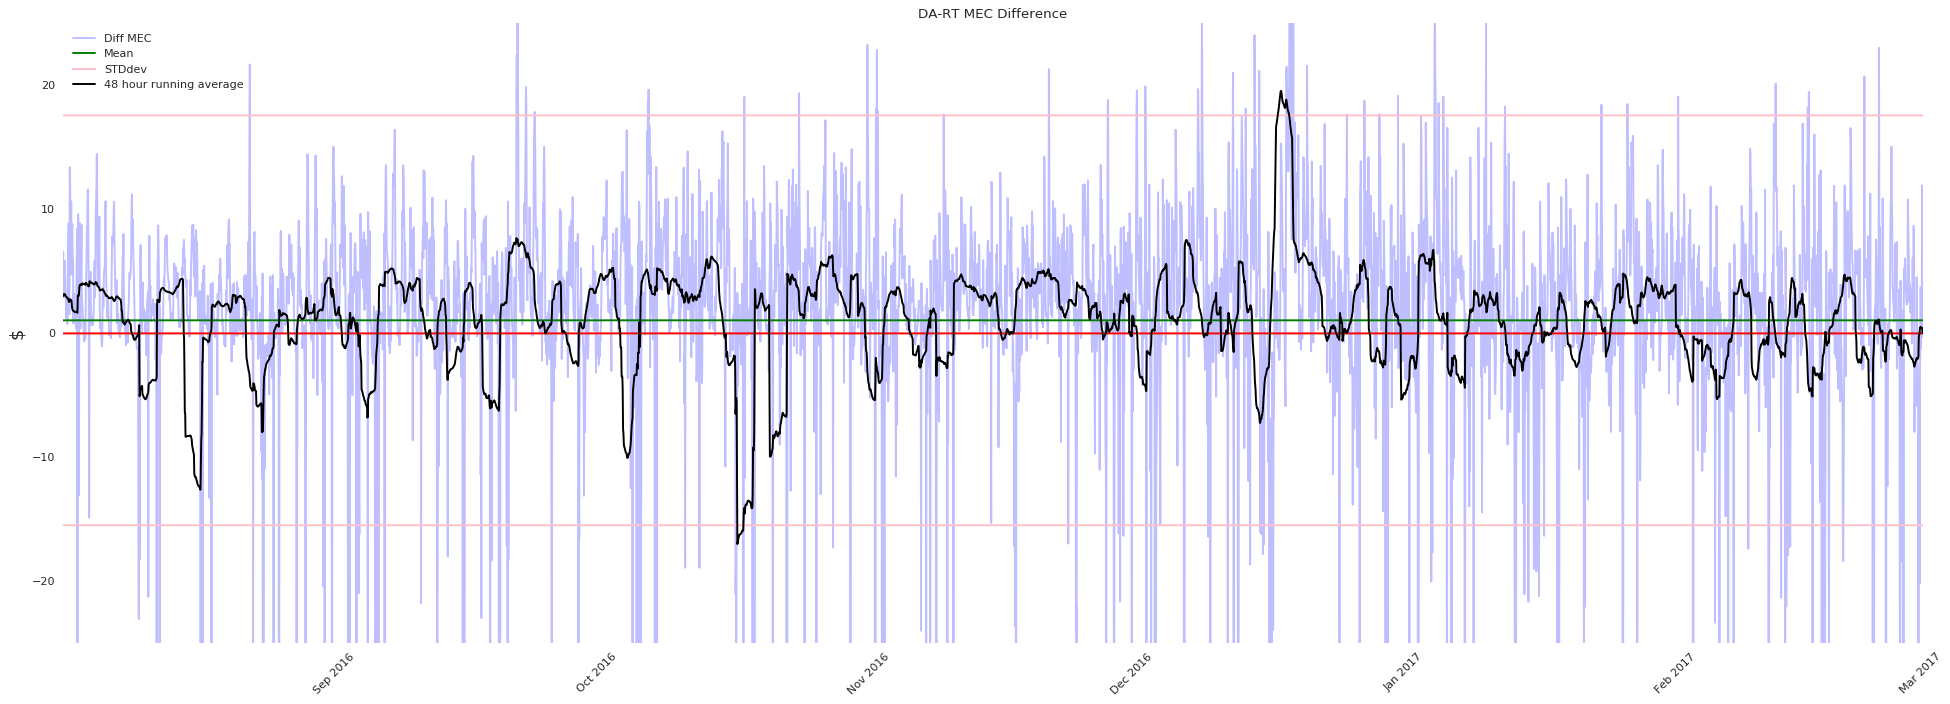

In [89]:
#plt.plot(obdates,mdf['mec'],color='red', label='DA MEC')
#plt.plot(obdates,mdf['rtmec'],color='blue', label='RT MEC')
plt.plot(obdates,mdf['diffmec'],color='blue', label='Diff MEC', alpha=0.25)
plt.plot(obdates,[0]*len(obdates),color='red')
plt.plot(obdates,[mdf['diffmec'].mean()]*len(obdates),color='green', label='Mean')
plt.plot(obdates,[mdf['diffmec'].std()+mdf['diffmec'].mean()]*len(obdates),color='pink', label='STDdev')
plt.plot(obdates,[mdf['diffmec'].mean() - mdf['diffmec'].std()]*len(obdates),color='pink')
runnavg = 48
#THis running mean seems to be looking forward...look more into before using
plt.plot(obdates, runningMean(mdf['diffmec'],runnavg), color='black', label='%s hour running average' % str(runnavg))
plt.legend(loc='upper left')
#plt.xlabel('time', fontsize=18)
plt.ylabel('$', fontsize=16)
plt.title('DA-RT MEC Difference')
xax = plt.gca().xaxis
yax = plt.gca().yaxis

plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
ax = plt.gca()
ax.set_ylim([-25,25])
ax.grid(False)
fig = plt.gcf()
fig.set_size_inches(30,10)
ax.set_axis_bgcolor('white')
for item in xax.get_ticklabels():
  item.set_rotation(45)
  
for spine in plt.gca().spines.values():
  spine.set_visible(False)
plt.subplots_adjust(bottom=0.25)
plt.show()


In [126]:
mdf.describe()

,Date,mec,rtmec,diffmec
count,5.094000e+03,5094.000000,5094.000000,5094.000000
mean,1.411311e+07,24.783158,23.726857,1.056301
std,5.264568e+06,9.168643,18.591004,16.526046
min,8.012016e+06,2.785700,-18.205000,-345.784700
25%,9.232016e+06,18.317450,16.897750,0.062250
50%,1.115202e+07,23.148600,20.407400,2.613550
75%,2.017011e+07,30.184475,26.367925,5.901825
max,2.017030e+07,131.898900,380.685800,110.639400


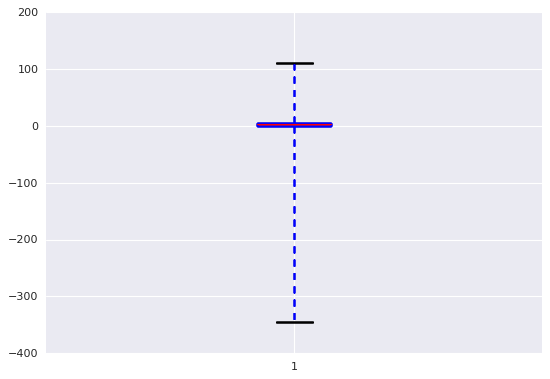

In [134]:
hours = list(set(r for r in mdf['Hour']))
hours.sort()
#for h in range(0,len(hours)):
  #xx = plt.subplot(len(hours),1,h+1)
plt.boxplot(mdf['diffmec'], whis='range')
fig = plt.gcf()
#fig.set_size_inches(10,70)

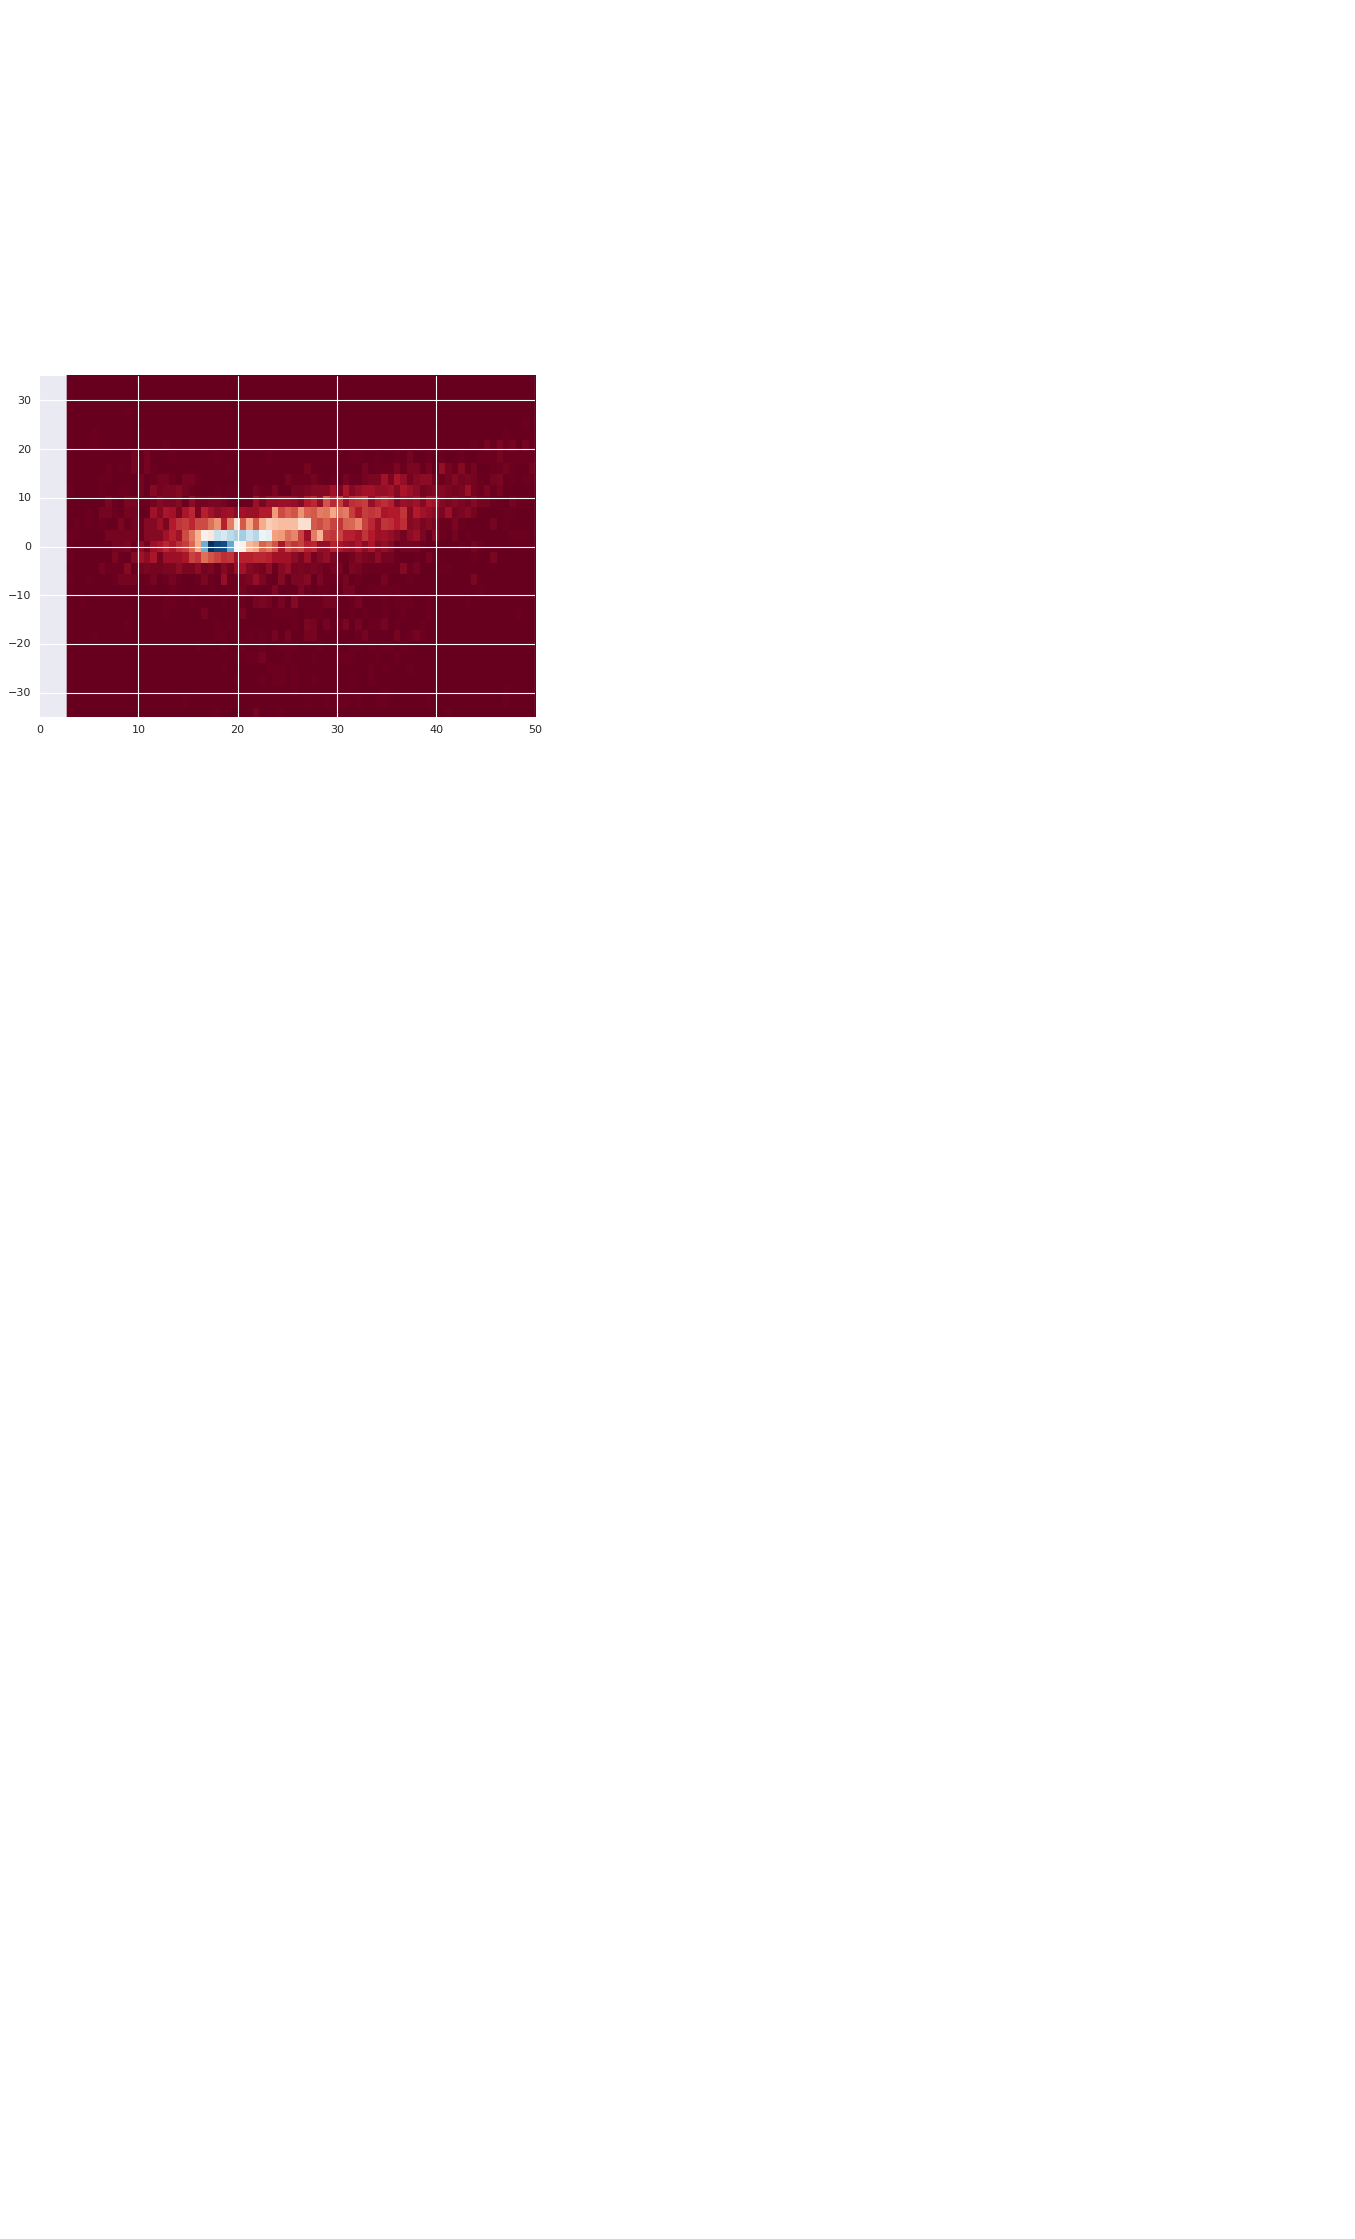

In [146]:
plt.hist2d(mdf['mec'],mdf['diffmec'], bins=200, cmap=plt.cm.get_cmap('RdBu'))
ax = plt.gca()
ax.axis([0,50,-35,35])
#fig = plt.gcf()
#fig.set_size_inches(10,10)
plt.show()

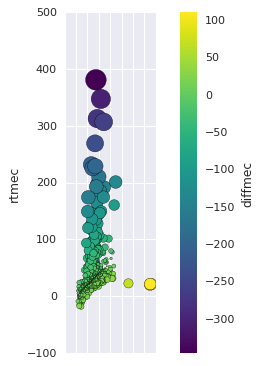

In [154]:
tstm = mdf.copy()
tstm.set_index(['Date','Hour'])
#tstm.plot('mec', 'rtmec', kind = 'scatter')
xxs = tstm.plot.scatter('mec', 'rtmec', c='diffmec', s=abs(tstm['diffmec']), colormap='viridis')
xxs.set_aspect('equal')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4063449150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f405006f910>]], dtype=object)

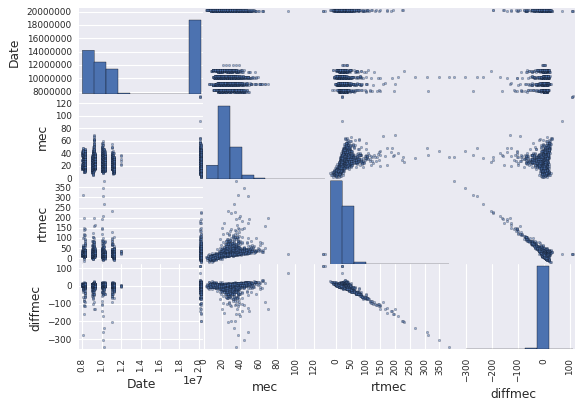

In [161]:
pd.tools.plotting.scatter_matrix(tstm)

KINDS: 
line
bar
barh
hist
box
kde
density
area
pie
scatter
hexbin

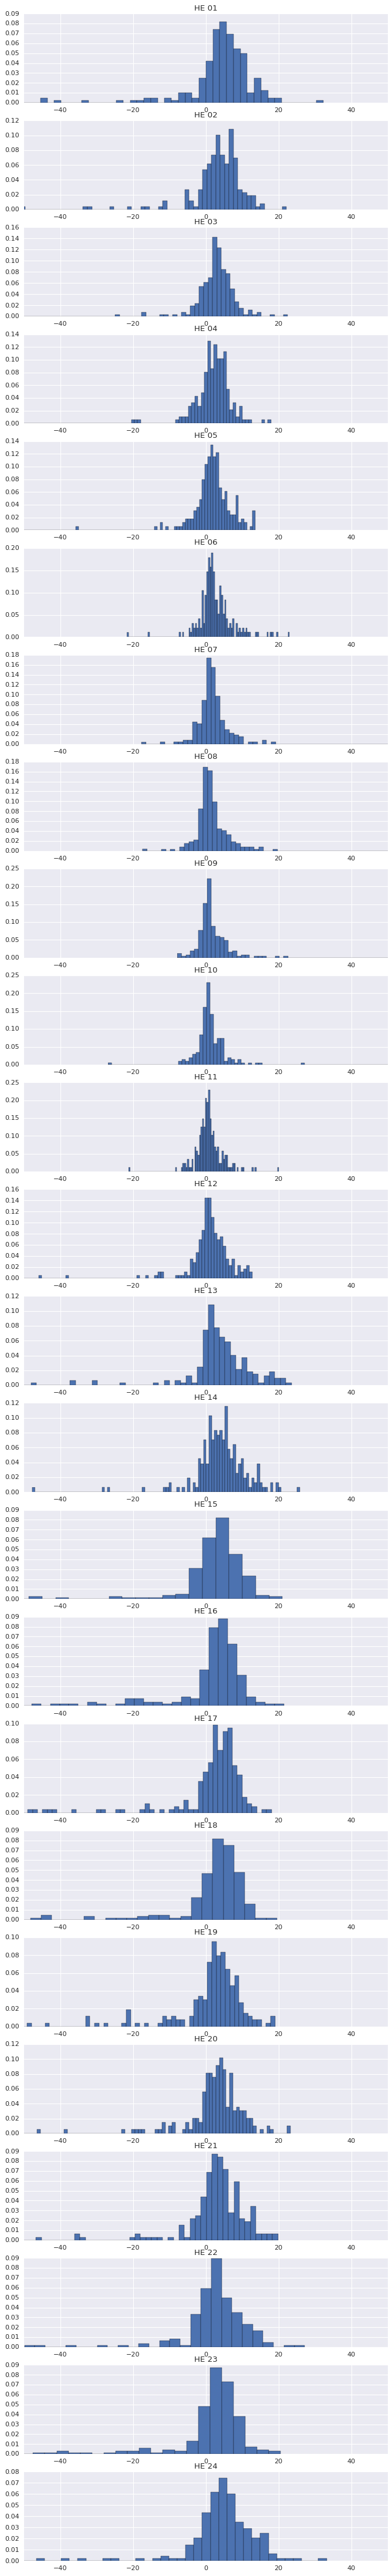

In [124]:
for h in range(0,len(hours)):
  xx = plt.subplot(len(hours),1,h+1)#,sharey=plt.subplot(len(hours),1,1), sharex=plt.subplot(len(hours),1,1))
  plt.hist(mdf[mdf['Hour'] == hours[h]]['diffmec'], bins=100, normed=True)
  plt.title('HE %s' % str(hours[h]) )
  ax = plt.gca()
  ax.set_xlim([-50,50])
fig = plt.gcf()

fig.set_size_inches(10,70)

In [5]:
print(mdf['mec'].mean())
print(mdf['mec'].median())
print(mdf['mec'].std())
print(mdf['mec'].min())
print(mdf['mec'].max())



houravgmec = []

for h in hours:
  hourmecsum = 0
  hourcount = 0
  for index, row in mdf.iterrows():
    if row['Hour'] == h:
      hourmecsum += float(row['mec'])
      hourcount += 1
  houravgmec.append((h, hourmecsum/hourcount))
  
houravgmec.sort(key=lambda x: x[0])
print(houravgmec)

24.7831576168
23.1486
9.16864330618
2.7857
131.8989
[('01', 30.943974647887323), ('02', 27.469023004694826), ('03', 24.399170422535196), ('04', 21.352051643192507), ('05', 19.005552112676053), ('06', 17.532017370892017), ('07', 17.785279245283018), ('08', 17.376483962264146), ('09', 17.20840849056603), ('10', 17.333396698113205), ('11', 18.37640518867925), ('12', 21.40532405660377), ('13', 25.633180188679255), ('14', 26.7895466981132), ('15', 27.260205660377352), ('16', 28.67567358490566), ('17', 28.910110849056586), ('18', 29.049609433962274), ('19', 29.1025603773585), ('20', 28.921006132075476), ('21', 29.43409575471699), ('22', 29.626507547169812), ('23', 29.128808962264113), ('24', 32.11511320754715)]


In [6]:
print(rdf['mec'].mean())
print(rdf['mec'].median())
print(rdf['mec'].std())
print(rdf['mec'].min())
print(rdf['mec'].max())

#hours = set(r for r in rdf['Hour'])

rthouravgmec = []

for h in hours:
  hourmecsum = 0
  hourcount = 0
  for index, row in rdf.iterrows():
    if row['Hour'] == h:
      hourmecsum += float(row['mec'])
      hourcount += 1
  rthouravgmec.append((h, hourmecsum/hourcount))
  
rthouravgmec.sort(key=lambda x: x[0])
print(rthouravgmec)

23.7268570868
20.4074
18.5910042581
-18.205
380.6858
[('01', 29.383280751173707), ('02', 24.699837558685445), ('03', 21.83104600938968), ('04', 19.49138122065726), ('05', 17.333549295774652), ('06', 14.854427230046952), ('07', 15.464661320754724), ('08', 15.193584433962267), ('09', 14.8875108490566), ('10', 15.800558962264143), ('11', 17.47667169811322), ('12', 20.637229716981146), ('13', 22.757035377358484), ('14', 22.58296320754716), ('15', 26.920973584905646), ('16', 33.084978773584915), ('17', 29.596491037735866), ('18', 31.671940094339607), ('19', 28.921571226415086), ('20', 26.76609150943395), ('21', 29.001774999999995), ('22', 30.3407745283019), ('23', 29.650258018867923), ('24', 31.165637264150952)]


In [7]:
print(mdf['diffmec'].mean())
print(mdf['diffmec'].median())
print(mdf['diffmec'].std())
print(mdf['diffmec'].min())
print(mdf['diffmec'].max())


houravgdiff = []

for h in hours:
  hourmecsum = 0
  hourcount = 0
  for index, row in mdf.iterrows():
    if row['Hour'] == h:
      hourmecsum += float(row['diffmec'])
      hourcount += 1
  houravgdiff.append((h, hourmecsum/hourcount))
  
houravgdiff.sort(key=lambda x: x[0])
print(houravgdiff)

1.05630053004
2.61355
16.5260463784
-345.7847
110.6394
[('01', 1.5606938967136126), ('02', 2.7691854460093888), ('03', 2.5681244131455365), ('04', 1.860670422535212), ('05', 1.6720028169014078), ('06', 2.677590140845072), ('07', 2.320617924528302), ('08', 2.182899528301886), ('09', 2.320897641509435), ('10', 1.532837735849056), ('11', 0.8997334905660376), ('12', 0.7680943396226413), ('13', 2.8761448113207546), ('14', 4.2065834905660395), ('15', 0.3392320754716991), ('16', -4.409305188679245), ('17', -0.6863801886792452), ('18', -2.6223306603773557), ('19', 0.1809891509433958), ('20', 2.154914622641511), ('21', 0.43232075471698095), ('22', -0.7142669811320759), ('23', -0.5214490566037736), ('24', 0.9494759433962268)]


In [13]:
hourmec = []
for h in hours:
  hm = mdf.loc[mdf['Hour'] == h]
  hourmec.append((h, hm))
hourmec.sort(key=lambda x: x[0])

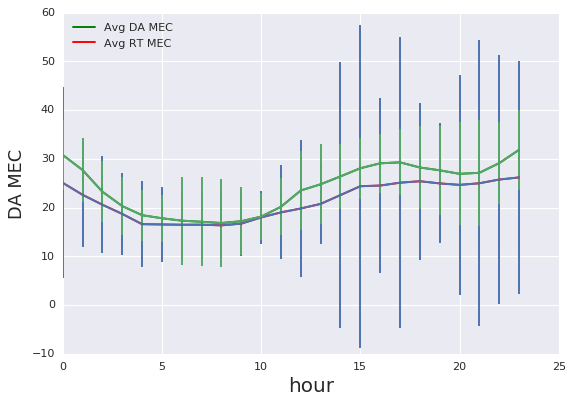

In [14]:
price = [x[1] for x in houravgmec]
rtprice = [x[1]['rtmec'].mean() for x in hourmec]
maxprice = [x[1]['mec'].max() for x in hourmec]
minprice = [x[1]['mec'].min() for x in hourmec]
rtmaxprice = [x[1]['rtmec'].max() for x in hourmec]
rtminprice = [x[1]['rtmec'].min() for x in hourmec]
stdprice = [x[1]['mec'].std() for x in hourmec]
rtstdprice = [x[1]['rtmec'].std() for x in hourmec]
medianprice = [x[1]['mec'].median() for x in hourmec]
rtmedianprice = [x[1]['rtmec'].median() for x in hourmec]

t = np.arange(0,len(price),1)
plt.plot(t,medianprice,color='green', label='Avg DA MEC')
plt.plot(t,rtmedianprice,color='red', label='Avg RT MEC')
#plt.plot(t,maxprice,color='red', label='Max MEC')
#plt.plot(t,minprice,color='blue', label='Min MEC')
plt.errorbar(t,rtmedianprice,rtstdprice,0)
plt.errorbar(t,medianprice,stdprice,0)
#plt.plot(t,medianprice,color='orange', label='Median MEC')
#plt.plot(t,stdprice,color='yellow', label='err')

plt.legend(loc='upper left')
plt.xlabel('hour', fontsize=18)
plt.ylabel('DA MEC', fontsize=16)
plt.show()

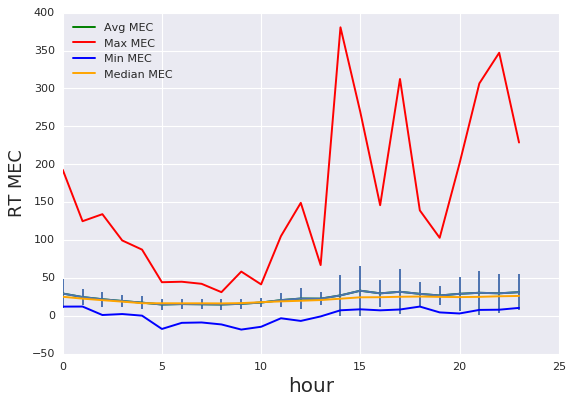

In [15]:
t = np.arange(0,len(rtprice),1)
plt.plot(t,rtprice,color='green', label='Avg MEC')
plt.plot(t,rtmaxprice,color='red', label='Max MEC')
plt.plot(t,rtminprice,color='blue', label='Min MEC')
plt.errorbar(t,rtprice,rtstdprice,0)
plt.plot(t,rtmedianprice,color='orange', label='Median MEC')
#plt.plot(t,stdprice,color='yellow', label='err')

plt.legend(loc='upper left')
plt.xlabel('hour', fontsize=18)
plt.ylabel('RT MEC', fontsize=16)
plt.show()

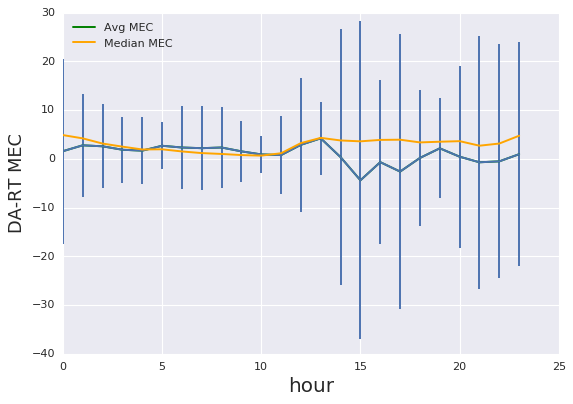

In [16]:
diffmaxprice = [x[1]['diffmec'].max() for x in hourmec]
diffminprice = [x[1]['diffmec'].min() for x in hourmec]
diffstdprice = [x[1]['diffmec'].std() for x in hourmec]
diffmedianprice = [x[1]['diffmec'].median() for x in hourmec]
diffavgprice = [x[1]['diffmec'].mean() for x in hourmec]

t = np.arange(0,len(diffavgprice),1)
plt.plot(t,diffavgprice,color='green', label='Avg MEC')
#plt.plot(t,diffmaxprice,color='red', label='Max MEC')
#plt.plot(t,diffminprice,color='blue', label='Min MEC')
plt.errorbar(t,diffavgprice,diffstdprice,0)
plt.plot(t,diffmedianprice,color='orange', label='Median MEC')
#plt.plot(t,stdprice,color='yellow', label='err')

plt.legend(loc='upper left')
plt.xlabel('hour', fontsize=18)
plt.ylabel('DA-RT MEC', fontsize=16)
plt.show()


In [38]:
#hip = x[1].where(abs(x[1]['diffmec']) > 10)
#hip = hip.dropna()
#below drops na automatically
hip = x[1][abs(x[1]['diffmec'])>10]
hip.count()

hip.head()

,Date,Hour,mec,rtmec,diffmec
13,8012016,24,38.2829,27.6514,10.6315
373,8162016,24,34.2647,121.3594,-87.0947
397,8172016,24,31.7197,103.4942,-71.7745
661,8282016,24,34.4516,21.6697,12.7819
685,8292016,24,37.6665,27.5581,10.1084


In [119]:
tsthr = mdf.copy()
tsthr = tsthr.set_index(['Date','Hour'])
#tsthr['Hour'].unique()
#tsthr.loc[8012016,'01']
tsthr.loc[[(9222016, '04'),(9242016, '07')]]
tsthr.sort_index()
#forward fill for na values
#can do it for singular, multiple or all columns
#fillna could put explicit value
tsthr.ffill()
tsthr.head()

mec    rtmec  diffmec
Date    Hour                           
8012016 01    28.9543  23.4502   5.5041
        02    28.1353  21.5661   6.5692
        03    23.0198  19.0606   3.9592
        04    20.2738  17.3855   2.8883
        05    19.6931  16.4011   3.2920

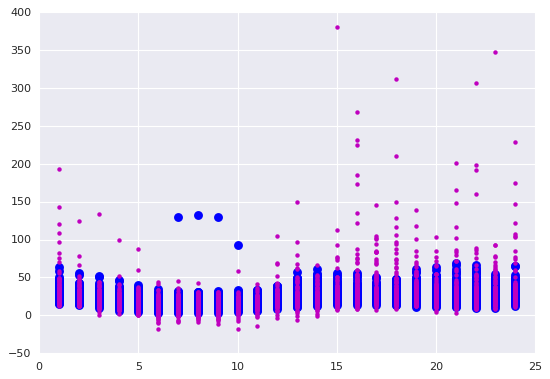

In [267]:
plt.plot(mdf.Hour, mdf.mec, 'o',label=mdf.Date, c='b', ms=8)
plt.plot(mdf.Hour, mdf.rtmec, 'o',label=mdf.Date, c='m', ms=4)

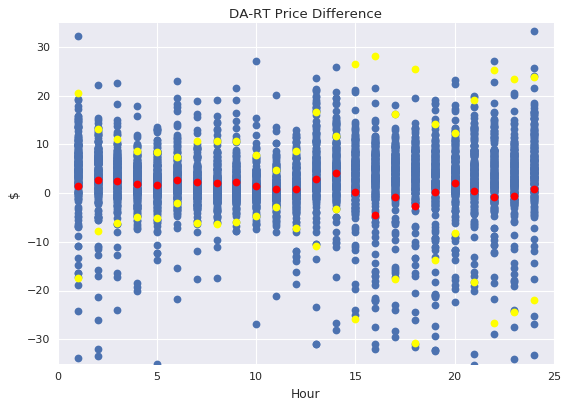

In [88]:
plt.plot(mdf.Hour, mdf.diffmec, 'o',label=mdf.Date)
ax = plt.gca()
ax.axis([0,25,-35,35])
plt.xlabel('Hour')
plt.ylabel('$')
plt.title('DA-RT Price Difference')


for group, frame in mdf.groupby('Hour'):
  avg = np.mean(frame['diffmec'])
  std = np.std(frame['diffmec'])
  plt.plot(group, avg, 'o', label='Mean', c='red')
  plt.plot(group, avg + std, 'o', label='STDDev', c='yellow')
  plt.plot(group, avg - std, 'o', c='yellow')




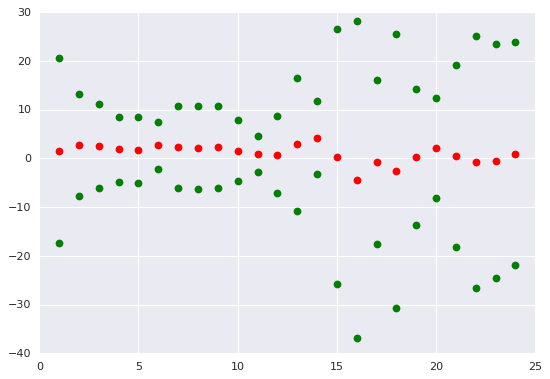

In [67]:
for group, frame in mdf.groupby('Hour'):
  avg = np.average(frame['diffmec'])
  std = np.std(frame['diffmec'])
  plt.plot(group, avg, 'o', label='Average', c='red')
  plt.plot(group, avg + std, 'o', label='Average', c='green')
  plt.plot(group, avg - std, 'o', label='Average', c='green')


In [271]:
mdf.head()
mdf.loc[mdf['rtmec'] > 150]

,Date,Hour,mec,rtmec,diffmec
262,8112016,18,37.2587,312.4772,-275.2185
370,8162016,22,38.1793,198.1560,-159.9767
1187,9192016,21,69.6056,200.8569,-131.2513
1186,9192016,22,67.0768,160.3503,-93.2735
1403,9282016,21,36.4870,164.8967,-128.4097
1570,10052016,22,49.1202,191.4933,-142.3731
1894,10182016,18,40.0347,210.0226,-169.9879
1882,10182016,22,48.6018,306.6488,-258.0470
1881,10182016,23,43.6123,347.0693,-303.4570
1985,10222016,15,34.9011,380.6858,-345.7847


In [59]:
#need to start chaining methods...

for group, frame in mdf.groupby('Hour'):
  avg = np.average(frame['diffmec'])
  std = np.std(frame['diffmec'])
  print('Hour ' + str(group) + ' have average Diff of ' + str(avg) + ' + std of ' + str(std))

Hour 01 have average Diff of 1.56069389671 + std of 18.9473306402
Hour 02 have average Diff of 2.76918544601 + std of 10.4967039001
Hour 03 have average Diff of 2.56812441315 + std of 8.62459416303
Hour 04 have average Diff of 1.86067042254 + std of 6.72916999866
Hour 05 have average Diff of 1.6720028169 + std of 6.8246817222
Hour 06 have average Diff of 2.67759014085 + std of 4.77109295271
Hour 07 have average Diff of 2.32061792453 + std of 8.40810429554
Hour 08 have average Diff of 2.1828995283 + std of 8.56207947435
Hour 09 have average Diff of 2.32089764151 + std of 8.32835762103
Hour 10 have average Diff of 1.53283773585 + std of 6.27182246002
Hour 11 have average Diff of 0.899733490566 + std of 3.77583649641
Hour 12 have average Diff of 0.768094339623 + std of 7.92519716634
Hour 13 have average Diff of 2.87614481132 + std of 13.723458779
Hour 14 have average Diff of 4.20658349057 + std of 7.51103231926
Hour 15 have average Diff of 0.339232075472 + std of 26.1742267079
Hour 16 hav

In [177]:
#show how to use function to group by
#mdf.reset_index()
#mdf = mdf.set_index('Date')
def year(item):
  if item > 20170000:
    return 0
  return 1

for group, frame in mdf.groupby(year):
  print('There are ' + str(len(frame)) + ' records in group ' + str(group))
  #if group == 0:
  #  print(frame)
  
#use df.cut to move data into categorical bins

There are 1422 records in group 0
There are 3672 records in group 1


In [159]:
mdf.pivot_table(values='diffmec', index='Hour', columns='mec', aggfunc=np.mean)

mec,2.7857,2.9317,3.1083,3.2409,3.9029,3.9895,4.578,4.9301,5.0843,5.2085,...,63.6993,64.6415,64.7639,66.4331,67.0768,69.6056,92.1657,130.1916,130.4157,131.8989
Hour,,,,,,,,,,,,,,,,,,,,,
01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05,NaN,NaN,NaN,NaN,NaN,NaN,-12.2312,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06,NaN,-6.4175,NaN,NaN,NaN,2.4657,NaN,NaN,NaN,3.9729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07,-1.9812,NaN,NaN,NaN,NaN,NaN,NaN,-7.9439,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.8539,NaN,NaN
08,NaN,NaN,11.9308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.6394
09,NaN,NaN,NaN,1.4785,NaN,NaN,NaN,NaN,7.5396,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0474,NaN


In [123]:
#this is just showing how to potentially use apply...not useful here really
def min_max(row):
  data = row[['mec',
              'rtmec',
              'diffmec']]
  #row['max'] = np.max(data)
  #row['min'] = np.min(data)
  #return row
  return pd.Series({'min': np.min(data), 'max': np.max(data)})

tsthr.apply(min_max, axis=1)

max      min
Date     Hour                  
8012016  01    28.9543   5.5041
         02    28.1353   6.5692
         03    23.0198   3.9592
         04    20.2738   2.8883
         05    19.6931   3.2920
         06    18.0559   3.5476
         07    16.7207   5.8657
         08    15.8937   3.6058
         09    15.4189   3.3288
         10    15.8906   1.4762
         11    17.2767   1.2336
         12    18.4088   2.7957
         13    18.9199   0.7538
         14    22.2882   1.3707
         15    24.0666   4.8946
         16    29.7481   7.8820
         17    35.2580   8.8713
         18    37.1288   2.4228
         19    40.5282   1.5457
         20    41.5645  13.3943
         21    42.9052  12.0490
         22    43.8774   8.6785
         23    38.9517   7.6402
         24    38.2829  10.6315
8022016  01    34.8423   4.7414
         02    33.3173   8.4055
         03    28.9438   8.8142
         04    24.3059   6.1411
         05    23.9648   5.8740
         06    19.2365   0.8082
...                ...      ...
20170228 01    21.8762   3.0934
         02    18.3152   6.0623
         03    14.4280   3.8378
         04    11.9714   5.4256
         05     9.3388   0.6739
         06     6.1135   2.2820
         07    12.8740  -7.9439
         08    10.9686  -4.6443
         09    10.6664  -4.1507
         10    12.2254  -5.4687
         11    13.6494  -5.6679
         12    17.2559  -5.8277
         13    22.7226   4.5216
         14    19.4425   0.7610
         15    20.3253  -2.2532
         16    21.9893  -2.5527
         17    24.4174  -5.6112
         18    93.4855 -75.6100
         19    26.9411  -9.7366
         20    21.6520  -4.6360
         21    36.4740 -20.1740
         22    19.7031  -3.5214
         23    18.1221  -1.1856
         24    16.8074   3.7234
20170301 01    22.0839  -1.2206
         02    18.7123   1.9541
         03    16.9305  -0.2795
         04    14.2374   2.3025
         05     9.7113   2.1649
         06     6.8771   1.3101

[5094 rows x 2 columns]

In [126]:
rows = ['mec',
         'rtmec',
         'diffmec']
#using lambda functions in apply
tsthr.apply(lambda x: np.max(x[rows]), axis=1)

Date      Hour
8012016   01      28.9543
          02      28.1353
          03      23.0198
          04      20.2738
          05      19.6931
          06      18.0559
          07      16.7207
          08      15.8937
          09      15.4189
          10      15.8906
          11      17.2767
          12      18.4088
          13      18.9199
          14      22.2882
          15      24.0666
          16      29.7481
          17      35.2580
          18      37.1288
          19      40.5282
          20      41.5645
          21      42.9052
          22      43.8774
          23      38.9517
          24      38.2829
8022016   01      34.8423
          02      33.3173
          03      28.9438
          04      24.3059
          05      23.9648
          06      19.2365
                   ...   
20170228  01      21.8762
          02      18.3152
          03      14.4280
          04      11.9714
          05       9.3388
          06       6.1135
          07      12.87

In [31]:
t = time.time()
dtnow = dt.datetime.fromtimestamp(t)
delta = dt.timedelta(days = 10)
nd = dtnow - delta
nd

datetime.datetime(2017, 3, 11, 17, 52, 40, 89202)

In [162]:
pd.Timestamp('9/22/2016 10:00AM')

##period
pd.Period('1/2016')
pd.Period('3/5/2016')


Period('2016-03-05', 'D')

In [164]:
t1 = pd.Series(list('abc'), [pd.Timestamp('2016-09-01'),pd.Timestamp('2016-09-02'),pd.Timestamp('2016-09-02')])
t1

t2 = pd.Series(list('def'), [pd.Period('2016-09-01'),pd.Period('2016-09-02'),pd.Period('2016-09-02')])
t2

2016-09-01    d
2016-09-02    e
2016-09-02    f
Freq: D, dtype: object

In [181]:
d1 = ['16 June 2016', 'Aug 2, 2011', '20150626', '20100624']
ts3 = pd.DataFrame(np.random.randint(10,100,(4,2)), index= d1, columns=list('ab'))
ts3.index = pd.to_datetime(ts3.index)
ts3

,a,b
2016-06-16,52,28
2011-08-02,21,25
2015-06-26,41,48
2010-06-24,33,87


In [184]:
pd.Timestamp('9/3/2016')-pd.Timestamp('9/1/2016') + pd.Timedelta('5D 2H')

pd.Timestamp('9/1/2016') + pd.Timedelta('5D 2H')

Timestamp('2016-09-06 02:00:00')

In [186]:
dates = pd.date_range('01-01-2016', periods=366, freq='1D')
dates

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=366, freq='D')

In [198]:
ddf = pd.DataFrame({'Count1': 100 + np.random.randint(-5,10,366).cumsum(),
                   'Count2': 120 + np.random.randint(-5,10,366).cumsum()}, index=dates)
ddf
#ddf.index.weekday_name

,Count1,Count2
2016-01-01,97,123
2016-01-02,101,129
2016-01-03,102,134
2016-01-04,103,139
2016-01-05,105,143
2016-01-06,114,150
2016-01-07,114,156
2016-01-08,116,153
2016-01-09,116,158
2016-01-10,111,154


In [199]:
ddf.diff()

,Count1,Count2
2016-01-01,NaN,NaN
2016-01-02,4.0,6.0
2016-01-03,1.0,5.0
2016-01-04,1.0,5.0
2016-01-05,2.0,4.0
2016-01-06,9.0,7.0
2016-01-07,0.0,6.0
2016-01-08,2.0,-3.0
2016-01-09,0.0,5.0
2016-01-10,-5.0,-4.0


In [200]:
ddf.resample('M').mean()
ddf['2016-12']
ddf['2016-11':]

,Count1,Count2
2016-11-01,567,749
2016-11-02,568,753
2016-11-03,577,757
2016-11-04,574,765
2016-11-05,571,773
2016-11-06,580,768
2016-11-07,577,770
2016-11-08,583,776
2016-11-09,584,785
2016-11-10,592,782


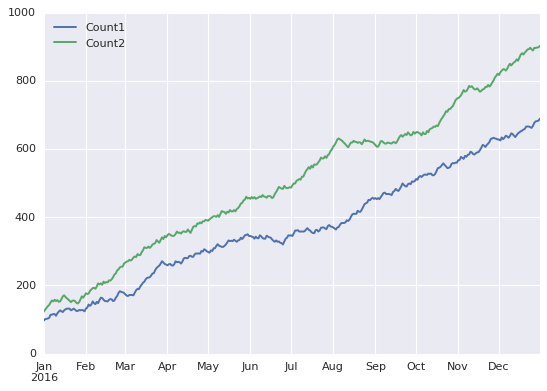

In [201]:
ddf.plot()

In [231]:
#more plots
#np.random.binomial(1, 0.5)
#np.random.binomial(1000, 0.1)

chance_of_tornado = 0.01
tdays = 1000000
tornado_events = np.random.binomial(1, chance_of_tornado, tdays)

two_days_in_a_row = 0
for j in range(1, len(tornado_events)-1):
  if tornado_events[j] == 1 and tornado_events[j-1] == 1:
    two_days_in_a_row += 1
    
print('{} tornadoes back to back in {} years.'.format(two_days_in_a_row, tdays/365))



90 tornadoes back to back in 2739 years.


In [235]:
np.random.uniform(0,1)
np.random.normal(0.75)
distribution = np.random.normal(0.75, size=1000)
#std dev
np.sqrt(np.sum((np.mean(distribution)-distribution)**2)/len(distribution))

0.98497636959065504

In [236]:
np.std(distribution)

0.98497636959065504

In [237]:
import scipy.stats as stats
stats.kurtosis(distribution)

-0.11368979214405828

In [238]:
stats.skew(distribution)

-0.05958849036736373

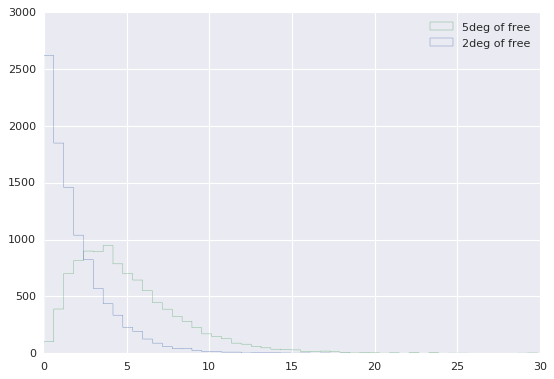

In [245]:
#Chi squared distribution
chi_sq_df2 = np.random.chisquare(2, size=10000)
stats.skew(chi_sq_df2)

chi_sq_df5 = np.random.chisquare(5, size=10000)
stats.skew(chi_sq_df5)

output = plt.hist([chi_sq_df2, chi_sq_df5], bins=50, histtype='step', label=['2deg of free', '5deg of free'])
plt.legend(loc='upper right')

In [ ]:
#Gaussian mixture models or 2 normal dists

#hypothesis testing...



In [178]:
#NEED to change the dates that start with month to start with year instead
mdf.index = pd.to_datetime(str(mdf.index))
mdf

ValueError: Unknown string format

In [5]:
%projects set drwgry-proj

In [8]:
%bigquery schema --table "sppda_2016_8.t1"

In [10]:
%sql
SELECT Date AS daynumber FROM [sppda_2016_8.t1] LIMIT 10

daynumber
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
